# Modélisation 

In [377]:
import pandas as pd
import seaborn as sns 
import matplotlib.pyplot as plt
import numpy as np
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
from sklearn.model_selection import cross_validate
from xgboost import XGBRegressor
from sklearn.model_selection import cross_val_score, KFold
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.model_selection import GridSearchCV

In [378]:
# ==============================================================
# 🧠 Fonction d'évaluation modèle
# ==============================================================

def evaluate_model(name, model, X_train, y_train, X_test, y_test, cv=5):
    """
    Entraîne, évalue et compare un modèle.
    Retourne un dictionnaire de résultats.
    """
    # --- Cross-validation sur le jeu d'entraînement ---
    cv_results = cross_validate(model, X_train, y_train, cv=cv, scoring='r2', return_train_score=True)
    
    # --- Entraînement sur tout le jeu d'entraînement ---
    model.fit(X_train, y_train)
    
    # --- Évaluation sur le jeu d'entraînement ---
    y_train_pred = model.predict(X_train)
    train_r2 = r2_score(y_train, y_train_pred)
    
    # --- Évaluation sur le jeu de test ---
    y_test_pred = model.predict(X_test)
    test_r2 = r2_score(y_test, y_test_pred)
    test_mae = mean_absolute_error(y_test, y_test_pred)
    test_rmse = np.sqrt(mean_squared_error(y_test, y_test_pred))
    
    # --- Résumé ---
    print(f"\n=== {name} ===")
    print(f"CV R² moyen : {cv_results['test_score'].mean():.3f} (+/- {cv_results['test_score'].std():.3f})")
    print(f"Train R² : {train_r2:.3f} | Test R² : {test_r2:.3f}")
    print(f"Test MAE : {test_mae:,.0f} | Test RMSE : {test_rmse:,.0f}")
    
    return {
        "Modèle": name,
        "CV_R2_Moyen": cv_results['test_score'].mean(),
        "Train_R2": train_r2,
        "Test_R2": test_r2,
        "Test_MAE": test_mae,
        "Test_RMSE": test_rmse
    }

In [379]:
# Chargement
df_filtré = pd.read_parquet("mon_dataset.parquet", engine="pyarrow")
buildings_initial = pd.read_csv("2016_Building_Energy_Benchmarking.csv")
display(buildings_initial.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3376 entries, 0 to 3375
Data columns (total 46 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   OSEBuildingID                    3376 non-null   int64  
 1   DataYear                         3376 non-null   int64  
 2   BuildingType                     3376 non-null   object 
 3   PrimaryPropertyType              3376 non-null   object 
 4   PropertyName                     3376 non-null   object 
 5   Address                          3376 non-null   object 
 6   City                             3376 non-null   object 
 7   State                            3376 non-null   object 
 8   ZipCode                          3360 non-null   float64
 9   TaxParcelIdentificationNumber    3376 non-null   object 
 10  CouncilDistrictCode              3376 non-null   int64  
 11  Neighborhood                     3376 non-null   object 
 12  Latitude            

None

# 🔧 Feature Engineering

Dans cette partie, nous allons enrichir notre dataset avec des informations utiles pour le modèle, sans introduire de fuite de données (*data leakage*).  
L’objectif est de créer des features structurelles, liées au type d’usage et à la localisation du bâtiment.

---

### 1️⃣ Features structurelles

- **Surface totale** : `PropertyGFATotal`  
- **Nombre d’étages** : `NumberofFloors`  
- **Âge du bâtiment** : calculé comme `Age = DataYear - YearBuilt`


In [380]:
# Sélectionner uniquement les colonnes à ajouter
colonnes_a_ajouter =  ["LargestPropertyUseType", "NumberofFloors", "Neighborhood", "DataYear","NumberofBuildings","PropertyGFAParking","LargestPropertyUseTypeGFA"]

In [381]:
# Fusionner avec df_filtré sur l'ID du bâtiment
df_filtré = df_filtré.merge(buildings_initial[["OSEBuildingID"] + colonnes_a_ajouter],
                            on="OSEBuildingID",
                            how="left")

#### Création de nouvelles features

 On peut créer plusieurs types de features :
- **Structurelles** : nombre d'étages, type principal d'usage
- **Temporelles** : âge du bâtiment
- **Localisation** : quartier (Neighborhood)

On évite toute feature basée sur la consommation d'énergie pour éviter le data leakage.


In [382]:
display(df_filtré.shape)

(1235, 12)

In [383]:
# 🏗️ 1. Âge du bâtiment
df_filtré["BuildingAge"] = df_filtré["DataYear"] - df_filtré["YearBuilt"]

# 📏 2. Surface par étage (densité verticale)
df_filtré["SurfaceParEtage"] = df_filtré["PropertyGFATotal"] / df_filtré["NumberofFloors"]
df_filtré["SurfaceParEtage"] = df_filtré["SurfaceParEtage"].replace([np.inf, -np.inf], np.nan).fillna(df_filtré["SurfaceParEtage"].median())

# 🏢 3. Catégorisation des bâtiments selon le nombre d’étages
df_filtré["SmallBuilding"] = (df_filtré["NumberofFloors"] <= 3).astype(int)
df_filtré["MediumBuilding"] = ((df_filtré["NumberofFloors"] > 3) & (df_filtré["NumberofFloors"] <= 10)).astype(int)
df_filtré["TallBuilding"] = (df_filtré["NumberofFloors"] > 10).astype(int)
# ❌ Suppression de la colonne originale
df_filtré.drop(columns=["NumberofFloors","DataYear","YearBuilt"], inplace=True)


In [384]:
display(df_filtré.shape)

(1235, 14)

In [359]:

# 1️⃣ Densité de bâtiment — rapport entre surface totale et surface parking

df_filtré["BuildingDensity"] = np.where(
    (df_filtré["PropertyGFAParking"] > 0),
    df_filtré["PropertyGFATotal"] / df_filtré["PropertyGFAParking"],
   0  # pas de parking => pas de densité
)


# 2️⃣ Catégorie d'âge
df_filtré["AgeCategory"] = pd.cut(
    df_filtré["BuildingAge"],
    bins=[0, 20, 50, np.inf],
    labels=["Neuf", "Moyen", "Vieux"],
    right=False)
# ✅ Indicateur de présence de parking
df_filtré["HasParking"] = (df_filtré["PropertyGFAParking"] > 0).astype(int)


In [385]:
df_filtré.shape

(1235, 14)

## Correlations entre Feautues / target

In [386]:
target = "SiteEnergyUseWN(kBtu)"
# Sélectionner toutes les colonnes numériques
numeric_cols = df_filtré.select_dtypes(include=["number"]).columns.tolist()

# Retirer la target
features_num = [col for col in numeric_cols if col != target]
display(features_num)

['OSEBuildingID',
 'PropertyGFATotal',
 'NumberofBuildings',
 'PropertyGFAParking',
 'LargestPropertyUseTypeGFA',
 'BuildingAge',
 'SurfaceParEtage',
 'SmallBuilding',
 'MediumBuilding',
 'TallBuilding']

Matrice de corrélation :
                            OSEBuildingID  PropertyGFATotal  NumberofBuildings  \
OSEBuildingID                   1.000000         -0.533251          -0.020103   
PropertyGFATotal               -0.533251          1.000000           0.026429   
NumberofBuildings              -0.020103          0.026429           1.000000   
PropertyGFAParking             -0.210673          0.531674           0.012986   
LargestPropertyUseTypeGFA      -0.434442          0.867235           0.058764   
BuildingAge                    -0.077299         -0.172102          -0.044541   
SurfaceParEtage                -0.285922          0.412907           0.041852   
SmallBuilding                   0.316808         -0.492404           0.009454   
MediumBuilding                 -0.288954          0.425668           0.001627   
TallBuilding                   -0.108413          0.237483          -0.033352   
SiteEnergyUseWN(kBtu)          -0.330521          0.522794           0.062761   

 

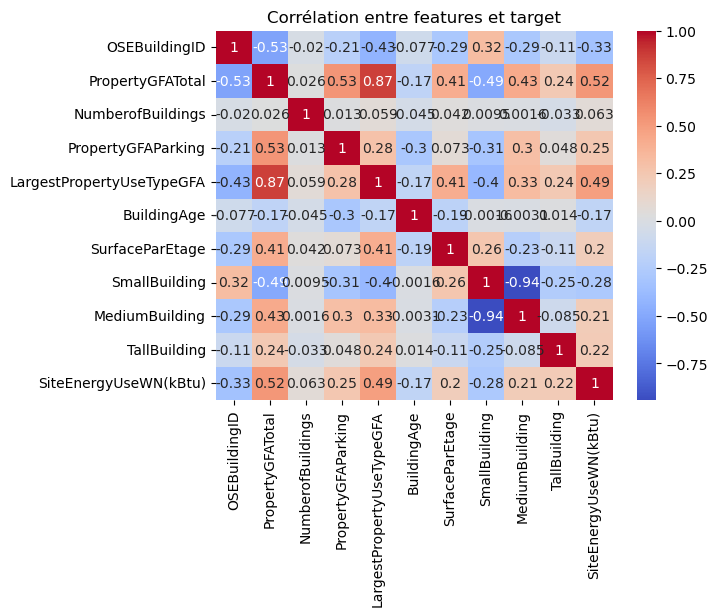

In [387]:
# Vérifier corrélation
corr_matrix = df_filtré[features_num + [target]].corr()
print("Matrice de corrélation :\n", corr_matrix)
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm')
plt.title("Corrélation entre features et target")
plt.show()

## 🔍 Corrélation entre les variables

| Relation | Corrélation | Interprétation |
|-----------|--------------|----------------|
| PropertyGFATotal ↔ SiteEnergyUse(kBtu) | **0.53** | Corrélation moyenne positive |
| LargestPropertyUseTypeGFA ↔ SiteEnergyUse(kBtu) | **0.49** | Corrélation moyenne positive |
| BuildingAge ↔ SiteEnergyUse(kBtu) | **-0.17** | Corrélation faible |


🔴 Rouge = corrélation forte  
🔵 Bleu = corrélation faible  

**Conclusion :**  
> La taille du bâtiment (PropertyGFATotal) influence le plus la consommation d’énergie.


In [363]:
#supprimer les features a faible correlation :  
df_filtré.drop(columns=["OSEBuildingID","NumberofBuildings"], inplace=True)
print(df_filtré.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1235 entries, 0 to 1234
Data columns (total 15 columns):
 #   Column                     Non-Null Count  Dtype   
---  ------                     --------------  -----   
 0   PrimaryPropertyType        1235 non-null   object  
 1   PropertyGFATotal           1235 non-null   int64   
 2   SiteEnergyUseWN(kBtu)      1232 non-null   float64 
 3   LargestPropertyUseType     1229 non-null   object  
 4   Neighborhood               1235 non-null   object  
 5   PropertyGFAParking         1235 non-null   int64   
 6   LargestPropertyUseTypeGFA  1229 non-null   float64 
 7   BuildingAge                1235 non-null   int64   
 8   SurfaceParEtage            1235 non-null   float64 
 9   SmallBuilding              1235 non-null   int64   
 10  MediumBuilding             1235 non-null   int64   
 11  TallBuilding               1235 non-null   int64   
 12  BuildingDensity            1235 non-null   float64 
 13  AgeCategory                1235 n

### Préparation du jeu de données pour la modélisation

À présent que nous avons enrichi notre DataFrame avec de nouvelles variables, 
nous allons le préparer pour l'entraînement d’un modèle : 

- Encodage des variables catégorielles
- Normalisation des variables numériques
- Séparation entraînement / test
- Sélection des variables explicatives (`X`)
- Définition de la variable cible (`y`)


In [364]:
# 🔹 Variables catégorielles
# -----------------------------
cat_cols = ['PrimaryPropertyType', 'LargestPropertyUseType','Neighborhood','AgeCategory']

# Limiter aux 10 catégories les plus fréquentes
for col in cat_cols:
    top_categories = df_filtré[col].value_counts().nlargest(10).index
    df_filtré[col] = df_filtré[col].apply(lambda x: x if x in top_categories else 'Other')

# One-Hot Encoding
df_encoded = pd.get_dummies(df_filtré, columns=cat_cols, drop_first=True)

# Supprimer les lignes avec NaN
df_encoded = df_encoded.dropna()
print("Shape après encodage et nettoyage :", df_encoded.shape)


Shape après encodage et nettoyage : (1228, 41)


### Résumé :
 - Le DataFrame filtré contient maintenant les colonnes originales pertinentes ainsi que des features nouvelles.
 - Les nouvelles features incluent le nombre d'étages en catégories, et des colonnes binaire pour le type    principal d'usage.
 - Ces features pourront être utilisées pour la modélisation sans risque de data leakage.
 - Les features ayant une corrélation faible ou négligeable avec la cible ont été retirées du dataset.

Le DataFrame final contient donc uniquement les variables pertinentes et non redondantes, prêtes pour l’étape de modélisation.

In [365]:
# -----------------------------
# ✅ 1️⃣ Séparation features / cible
# -----------------------------
target = "SiteEnergyUseWN(kBtu)"
X = df_encoded.drop(columns=target)
y = df_encoded[target]

# Split train / test
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)
print("Taille train :", X_train.shape, "Taille test :", X_test.shape)


Taille train : (982, 40) Taille test : (246, 40)


In [366]:
# -----------------------------
# 2️⃣ Scaling pour modèles linéaires et SVR
# -----------------------------
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


### 🧩 Vérification et interprétation

- Le dataset a été séparé en **80 % pour l'entraînement** et **20 % pour le test**.  
- Toutes les variables numériques ont été **standardisées** :  
  - Moyenne ≈ 0  
  - Écart-type ≈ 1  
- Cette étape permet d'éviter qu'une variable ayant une grande échelle (ex. surface) domine les autres.

Le dataset est maintenant prêt pour la phase de **modélisation (entraînement du modèle)**.


# 🧠 Modélisation & Évaluation 

In [367]:

# KFold pour Cross-validation
kfold = KFold(n_splits=5, shuffle=True, random_state=42)

# ================================
# 🧩 Étape 1 : Baseline - Linear Regression
# ================================
baseline_model = LinearRegression()
baseline_model.fit(X_train_scaled, y_train)

# Prédictions
y_train_pred = baseline_model.predict(X_train_scaled)
y_test_pred  = baseline_model.predict(X_test_scaled)

print("=== Linear Regression - Baseline ===")
print(f"Train → R²: {r2_score(y_train, y_train_pred):.3f}, RMSE: {np.sqrt(mean_squared_error(y_train, y_train_pred)):.2f}, MAE: {mean_absolute_error(y_train, y_train_pred):.2f}")
print(f"Test  → R²: {r2_score(y_test, y_test_pred):.3f}, RMSE: {np.sqrt(mean_squared_error(y_test, y_test_pred)):.2f}, MAE: {mean_absolute_error(y_test, y_test_pred):.2f}")


=== Linear Regression - Baseline ===
Train → R²: 0.572, RMSE: 1988482.65, MAE: 1377412.93
Test  → R²: 0.358, RMSE: 2737078.89, MAE: 1816209.36


In [368]:
# ================================
# 🧩 Étape 2 : Ridge et Lasso avec CV
# ================================
models = {
    "Ridge": Ridge(alpha=1.0),
    "Lasso": Lasso(alpha=0.01)
}

for name, model in models.items():
    cv_scores = cross_val_score(model, X_train_scaled, y_train, cv=kfold, scoring='r2')
    print(f"\n{name} - CV R² moyen = {cv_scores.mean():.3f} (+/- {cv_scores.std():.3f})")
    model.fit(X_train_scaled, y_train)
    y_train_pred = model.predict(X_train_scaled)
    y_test_pred  = model.predict(X_test_scaled)
    print(f"{name} → Train R²: {r2_score(y_train, y_train_pred):.3f}, Test R²: {r2_score(y_test, y_test_pred):.3f}")



Ridge - CV R² moyen = 0.512 (+/- 0.066)
Ridge → Train R²: 0.572, Test R²: 0.358

Lasso - CV R² moyen = 0.511 (+/- 0.066)
Lasso → Train R²: 0.572, Test R²: 0.358


C:\ProgramData\anaconda3\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.488e+15, tolerance: 7.388e+11
  model = cd_fast.enet_coordinate_descent(
C:\ProgramData\anaconda3\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.594e+15, tolerance: 7.294e+11
  model = cd_fast.enet_coordinate_descent(
C:\ProgramData\anaconda3\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 7.795e+13, toleranc

In [369]:
# ================================
# 🧩 Étape 3 : Modèles avancés (non linéaires) avec Cross-Validation
# ================================
advanced_models = {
    "Random Forest": RandomForestRegressor(n_estimators=100, random_state=42),
    "XGBoost": XGBRegressor(n_estimators=100, learning_rate=0.05, max_depth=3, random_state=42),
    "SVR (RBF)": SVR(kernel='rbf', C=10, epsilon=0.1)
}

for name, model in advanced_models.items():
    # Choisir le dataset selon modèle
    X_train_use = X_train_scaled if "SVR" in name else X_train
    cv_scores = cross_val_score(model, X_train_use, y_train, cv=kfold, scoring='r2')
    print(f"\n{name} → CV R² moyen : {cv_scores.mean():.3f} (+/- {cv_scores.std():.3f})")
    model.fit(X_train_use, y_train)
    y_train_pred = model.predict(X_train_use)
    X_test_use = X_test_scaled if "SVR" in name else X_test
    y_test_pred = model.predict(X_test_use)
    print(f"{name} → Train R²: {r2_score(y_train, y_train_pred):.3f}, Test R²: {r2_score(y_test, y_test_pred):.3f}")



Random Forest → CV R² moyen : 0.501 (+/- 0.076)
Random Forest → Train R²: 0.933, Test R²: 0.354

XGBoost → CV R² moyen : 0.539 (+/- 0.070)
XGBoost → Train R²: 0.672, Test R²: 0.396

SVR (RBF) → CV R² moyen : -0.138 (+/- 0.021)
SVR (RBF) → Train R²: -0.138, Test R²: -0.190


In [370]:
# ================================
# 🧩 Étape 4 : Hyperparameter tuning GridSearchCV pour RF et XGBoost
# ================================
# Random Forest
rf_param_grid = {
    "n_estimators": [100, 200],
    "max_depth": [None, 10, 20],
    "min_samples_split": [2, 5],
    "min_samples_leaf": [1, 2],
    "max_features": ['sqrt', 'log2']
}

rf_gs = GridSearchCV(RandomForestRegressor(random_state=42), rf_param_grid, cv=kfold, scoring='r2', n_jobs=-1)
rf_gs.fit(X_train, y_train)
best_rf = rf_gs.best_estimator_
y_train_pred = best_rf.predict(X_train)
y_test_pred  = best_rf.predict(X_test)
print(f"\nRandom Forest Meilleurs params: {rf_gs.best_params_}")
print(f"RF → Train R²: {r2_score(y_train, y_train_pred):.3f}, Test R²: {r2_score(y_test, y_test_pred):.3f}")

# XGBoost
xgb_param_grid = {
    "n_estimators": [100, 200],
    "max_depth": [3, 5],
    "learning_rate": [0.05, 0.1],
    "subsample": [0.6, 0.8],
    "colsample_bytree": [0.6, 0.8]
}

xgb_gs = GridSearchCV(XGBRegressor(random_state=42), xgb_param_grid, cv=kfold, scoring='r2', n_jobs=-1)
xgb_gs.fit(X_train, y_train)
best_xgb = xgb_gs.best_estimator_
y_train_pred = best_xgb.predict(X_train)
y_test_pred  = best_xgb.predict(X_test)
print(f"\nXGBoost Meilleurs params: {xgb_gs.best_params_}")
print(f"XGB → Train R²: {r2_score(y_train, y_train_pred):.3f}, Test R²: {r2_score(y_test, y_test_pred):.3f}")



Random Forest Meilleurs params: {'max_depth': 20, 'max_features': 'sqrt', 'min_samples_leaf': 2, 'min_samples_split': 5, 'n_estimators': 100}
RF → Train R²: 0.788, Test R²: 0.415

XGBoost Meilleurs params: {'colsample_bytree': 0.6, 'learning_rate': 0.05, 'max_depth': 3, 'n_estimators': 100, 'subsample': 0.8}
XGB → Train R²: 0.670, Test R²: 0.406


# Évaluation

In [372]:
# ================================
# 🧩 Étape : Évaluation finale du meilleur modèle
# ================================
# On choisit le meilleur modèle selon Test R²
models_test_r2 = {
    "Baseline": r2_score(y_test, baseline_model.predict(X_test_scaled)),
    "Ridge": r2_score(y_test, Ridge(alpha=1.0).fit(X_train_scaled, y_train).predict(X_test_scaled)),
    "Lasso": r2_score(y_test, Lasso(alpha=0.001).fit(X_train_scaled, y_train).predict(X_test_scaled)),
    "RF": r2_score(y_test, best_rf.predict(X_test)),
    "XGB": r2_score(y_test, best_xgb.predict(X_test))
}
best_model_name = max(models_test_r2, key=models_test_r2.get)
print(f"\n✅ Meilleur modèle global selon Test R² : {best_model_name}")


✅ Meilleur modèle global selon Test R² : RF


C:\ProgramData\anaconda3\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.941e+15, tolerance: 9.080e+11
  model = cd_fast.enet_coordinate_descent(


In [376]:
# ==============================================================
# 🚀 Comparaison de modèles
# ==============================================================

models = {
    "Régression Linéaire (Baseline)": LinearRegression(),
    "Ridge": Ridge(alpha=1.0),
    "Lasso": Lasso(alpha=0.001),
    "Random Forest": RandomForestRegressor(n_estimators=100, random_state=42),
    "XGBoost": XGBRegressor(n_estimators=200, learning_rate=0.05, max_depth=3, random_state=42),
    "SVR (RBF Kernel)": SVR(kernel='rbf', C=10, epsilon=0.1)
}

results = []

for name, model in models.items():
    res = evaluate_model(name, model, X_train_scaled, y_train, X_test_scaled, y_test)
    results.append(res)

# --- Tableau comparatif ---
results_df = pd.DataFrame(results).sort_values(by="Test_R2", ascending=False)
display(results_df)



=== Régression Linéaire (Baseline) ===
CV R² moyen : 0.535 (+/- 0.048)
Train R² : 0.572 | Test R² : 0.358
Test MAE : 1,816,209 | Test RMSE : 2,737,079

=== Ridge ===
CV R² moyen : 0.535 (+/- 0.048)
Train R² : 0.572 | Test R² : 0.358
Test MAE : 1,815,402 | Test RMSE : 2,737,112

=== Lasso ===
CV R² moyen : 0.535 (+/- 0.048)
Train R² : 0.572 | Test R² : 0.358
Test MAE : 1,816,485 | Test RMSE : 2,737,366


C:\ProgramData\anaconda3\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.623e+15, tolerance: 7.394e+11
  model = cd_fast.enet_coordinate_descent(
C:\ProgramData\anaconda3\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.820e+14, tolerance: 7.052e+11
  model = cd_fast.enet_coordinate_descent(
C:\ProgramData\anaconda3\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.409e+15, toleranc


=== Random Forest ===
CV R² moyen : 0.510 (+/- 0.055)
Train R² : 0.933 | Test R² : 0.354
Test MAE : 1,729,547 | Test RMSE : 2,744,199

=== XGBoost ===
CV R² moyen : 0.539 (+/- 0.055)
Train R² : 0.723 | Test R² : 0.393
Test MAE : 1,695,489 | Test RMSE : 2,661,773

=== SVR (RBF Kernel) ===
CV R² moyen : -0.141 (+/- 0.041)
Train R² : -0.138 | Test R² : -0.190
Test MAE : 2,449,453 | Test RMSE : 3,725,928


,Modèle,CV_R2_Moyen,Train_R2,Test_R2,Test_MAE,Test_RMSE
4,XGBoost,0.538646,0.723047,0.392555,1.695489e+06,2.661773e+06
0,Régression Linéaire (Baseline),0.535030,0.572349,0.357697,1.816209e+06,2.737079e+06
1,Ridge,0.535259,0.572314,0.357682,1.815402e+06,2.737112e+06
2,Lasso,0.534967,0.572335,0.357562,1.816485e+06,2.737366e+06
3,Random Forest,0.510407,0.933080,0.354351,1.729547e+06,2.744199e+06
5,SVR (RBF Kernel),-0.140866,-0.137894,-0.190239,2.449453e+06,3.725928e+06
